# Data poison

In [1]:
!pip freeze | grep -E "numpy|pandas|matplotlib|scikit-learn"

matplotlib==3.7.5
matplotlib-inline==0.1.7
numpy==1.24.4
pandas==2.0.3
scikit-learn==1.3.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

In [3]:
def generate_clean_dataset(n_samples=2000, noise=0.1):
    """
    Генерирует линейно разделимый датасет для бинарной классификации.
    """
    np.random.seed(42)
    
    # Класс 0: центр в точке (2, 2)
    X_class0 = np.random.randn(n_samples//2, 2) * 1.5 + np.array([2, 2])
    y_class0 = np.zeros(n_samples//2)
    
    # Класс 1: центр в точке (-2, -2)
    X_class1 = np.random.randn(n_samples//2, 2) * 1.5 + np.array([-2, -2])
    y_class1 = np.ones(n_samples//2)
    
    X = np.vstack([X_class0, X_class1])
    y = np.hstack([y_class0, y_class1])
    
    # Добавляем небольшой естественный шум
    X += np.random.randn(*X.shape) * noise
    
    df = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
    df['label'] = y.astype(int)
    
    return df



<Axes: >

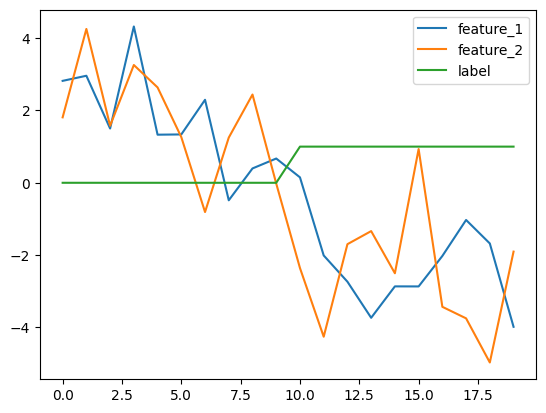

In [4]:
generate_clean_dataset(20).plot()

In [5]:
os.makedirs("data", exist_ok=True)
df = generate_clean_dataset()
df.to_csv("data/clean_train.csv", index=False)
df.to_csv("data/clean_test.csv", index=False) # Отдельный тестовый набор
print(f"Датасет создан: {len(df)} записей")
print(f"Распределение классов:\n{df['label'].value_counts()}")

Датасет создан: 2000 записей
Распределение классов:
label
0    1000
1    1000
Name: count, dtype: int64


## Baseline ML model learning

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import json

In [7]:
def train_and_evaluate(train_path, test_path, model_name="baseline"):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    X_train = train_df[['feature_1', 'feature_2']]
    y_train = train_df['label']
    X_test = test_df[['feature_1', 'feature_2']]
    y_test = test_df['label']
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results = {
        "model": model_name,
        "accuracy": float(acc),
        "report": classification_report(y_test, y_pred, output_dict=True)
    }
    
    # Сохранение метрик
    with open(f"results_{model_name}.json", "w") as f:
        json.dump(results, f, indent=2)
    
    joblib.dump(model, f"model_{model_name}.pkl")
    
    print(f"\nМодель: {model_name}")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   Classification Report:\n{classification_report(y_test, y_pred)}")
    
    return model, acc


In [8]:
train_and_evaluate("data/clean_train.csv", "data/clean_test.csv", "baseline")


Модель: baseline
   Accuracy: 0.9700
   Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



(LogisticRegression(max_iter=1000, random_state=42), 0.97)

In [9]:
!tree -L 1

.
├── attack_impact_chart.png
├── data
├── detection_results.png
├── Lab-2-2-data-poison.ipynb
├── model_baseline.pkl
├── model_poison_backdoor.pkl
├── model_poison_flip_20.pkl
├── model_poison_flip_40.pkl
├── results_baseline.json
├── results_poison_backdoor.json
├── results_poison_flip_20.json
├── results_poison_flip_40.json
├── results_summary.json
└── venv-2-2-data-poison

2 directories, 12 files


## Data Poisoning attack (TML0010)

In [10]:
class DataPoisoningAttack:
    """
    Реализация атак TML0010 из MITRE ATLAS
    """
    
    def __init__(self, filepath="data/clean_train.csv"):
        self.filepath = filepath
        self.original_df = pd.read_csv(filepath)
        self.poisoned_df = self.original_df.copy()
        
    def label_flipping_attack(self, flip_ratio=0.2, seed=42):
        """
        Атака 1: Инверсия меток (Label Flipping)
        Меняем метки у случайной доли обучающих примеров.
        """
        np.random.seed(seed)
        n_samples = len(self.poisoned_df)
        n_flip = int(n_samples * flip_ratio)
        
        # Выбираем случайные индексы
        flip_indices = np.random.choice(n_samples, n_flip, replace=False)
        
        # Инвертируем метки (0 -> 1, 1 -> 0)
        self.poisoned_df.loc[flip_indices, 'label'] = 1 - self.poisoned_df.loc[flip_indices, 'label']
        
        print(f"Label Flipping: изменено {n_flip} меток ({flip_ratio*100}%)")
        return self.poisoned_df
    
    def targeted_backdoor_attack(self, trigger_pattern, target_label, poison_ratio=0.1):
        """
        Атака 2: Целевой бэкдор (Targeted Backdoor)
        Внедряем паттерн-триггер в данные и меняем их метку на целевую.
        Модель научится ассоциировать триггер с целевым классом.
        """
        np.random.seed(42)
        n_samples = len(self.poisoned_df)
        n_poison = int(n_samples * poison_ratio)
        
        # Выбираем жертв (из класса, который хотим переназначить)
        source_class = 1 - target_label
        source_indices = self.poisoned_df[self.poisoned_df['label'] == source_class].index[:n_poison]
        
        # Внедряем триггер (смещение признаков)
        self.poisoned_df.loc[source_indices, 'feature_1'] += trigger_pattern[0]
        self.poisoned_df.loc[source_indices, 'feature_2'] += trigger_pattern[1]
        
        # Меняем метку на целевую
        self.poisoned_df.loc[source_indices, 'label'] = target_label
        
        print(f"Backdoor Attack: внедрено {n_poison} триггеров")
        print(f"   Триггер: {trigger_pattern}, Целевой класс: {target_label}")
        return self.poisoned_df
    
    def save_poisoned_data(self, output_path="data/poisoned_train.csv"):
        self.poisoned_df.to_csv(output_path, index=False)
        print(f"Отравленные данные сохранены: {output_path}")
        return output_path

## Label Flipping Attack

In [11]:
# Сценарий 1: Массовое отравление (20% данных)
attack1 = DataPoisoningAttack()
attack1.label_flipping_attack(flip_ratio=0.20)
attack1.save_poisoned_data("data/poisoned_flip_20.csv")

# Сценарий 2: Массовое отравление (40% данных)
attack2 = DataPoisoningAttack()
attack2.label_flipping_attack(flip_ratio=0.40)
attack2.save_poisoned_data("data/poisoned_flip_40.csv")

Label Flipping: изменено 400 меток (20.0%)
Отравленные данные сохранены: data/poisoned_flip_20.csv
Label Flipping: изменено 800 меток (40.0%)
Отравленные данные сохранены: data/poisoned_flip_40.csv


'data/poisoned_flip_40.csv'

## Backdoor Attack

In [12]:
# Сценарий 3: Целевой бэкдор
attack3 = DataPoisoningAttack()
# Триггер: смещение в правый верхний квадрант
attack3.targeted_backdoor_attack(
    trigger_pattern=[3.0, 3.0], 
    target_label=1, 
    poison_ratio=0.15
)
attack3.save_poisoned_data("data/poisoned_backdoor.csv")

Backdoor Attack: внедрено 300 триггеров
   Триггер: [3.0, 3.0], Целевой класс: 1
Отравленные данные сохранены: data/poisoned_backdoor.csv


'data/poisoned_backdoor.csv'

## Attacks Result analyze

In [13]:
scenarios = [
    ("baseline", "data/clean_train.csv"),
    ("poison_flip_20", "data/poisoned_flip_20.csv"),
    ("poison_flip_40", "data/poisoned_flip_40.csv"),
    ("poison_backdoor", "data/poisoned_backdoor.csv"),
]

results_summary = []

print("="*20)
print("АНАЛИЗ ВЛИЯНИЯ АТАК НА МОДЕЛЬ")
print("="*20)

for name, train_path in scenarios:
    print(f"\nСценарий: {name}")
    _, acc = train_and_evaluate(train_path, "data/clean_test.csv", name)
    results_summary.append({"scenario": name, "accuracy": acc})

# Сохранение сводки
with open("results_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*20)
print("СВОДНАЯ ТАБЛИЦА")
print("="*20)
for r in results_summary:
    print(f"{r['scenario']:20} | Accuracy: {r['accuracy']:.4f}")

АНАЛИЗ ВЛИЯНИЯ АТАК НА МОДЕЛЬ

Сценарий: baseline

Модель: baseline
   Accuracy: 0.9700
   Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


Сценарий: poison_flip_20

Модель: poison_flip_20
   Accuracy: 0.9690
   Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.97      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


Сценарий: poison_flip_40

Модель: poison_flip_40
   Accuracy: 0.9670
   Classification Report:
              precision    recall  f1-sc

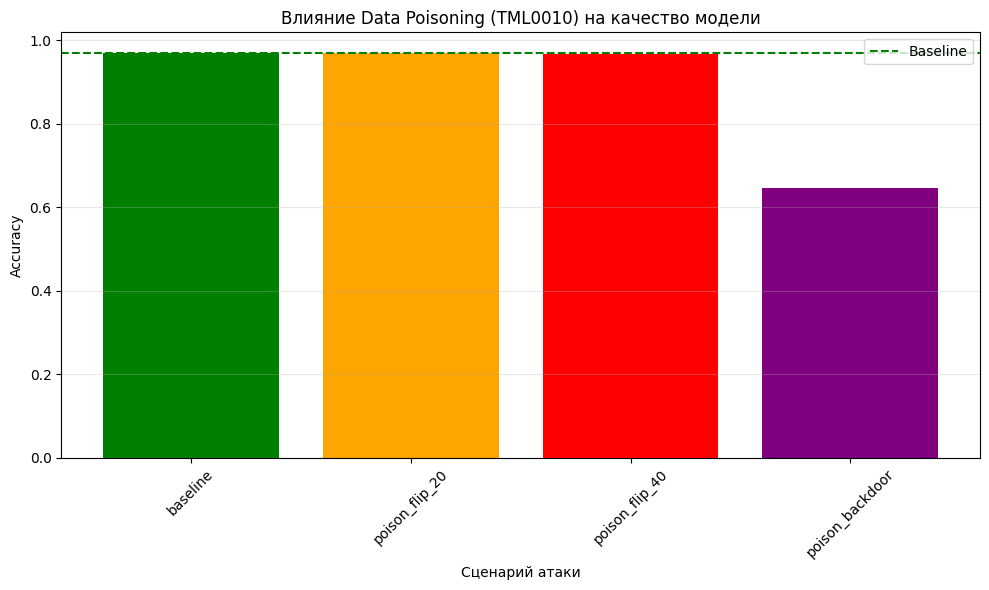

In [14]:
with open("results_summary.json") as f:
    data = json.load(f)

labels = [d['scenario'] for d in data]
accuracies = [d['accuracy'] for d in data]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['green', 'orange', 'red', 'purple'])
plt.axhline(y=accuracies[0], color='green', linestyle='--', label='Baseline')
plt.xlabel('Сценарий атаки')
plt.ylabel('Accuracy')
plt.title('Влияние Data Poisoning (TML0010) на качество модели')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("attack_impact_chart.png", dpi=300)
plt.show()

## Detection

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

In [16]:
class PoisoningDetector:
    def __init__(self, contamination=0.1):
        self.iso_forest = IsolationForest(
            contamination=contamination, 
            random_state=42
        )
        
    def fit_detect(self, df):
        """
        Обнаружение аномалий с помощью Isolation Forest
        """
        X = df[['feature_1', 'feature_2']]
        
        # Предсказание аномалий (-1 = аномалия, 1 = норма)
        predictions = self.iso_forest.fit_predict(X)
        
        df['anomaly_score'] = self.iso_forest.score_samples(X)
        df['is_anomaly'] = (predictions == -1).astype(int)
        
        n_anomalies = df['is_anomaly'].sum()
        print(f"Обнаружено аномалий: {n_anomalies} ({n_anomalies/len(df)*100:.2f}%)")
        
        return df
    
    def label_consistency_check(self, df):
        """
        Проверка согласованности меток в локальных окрестностях
        Если точка далеко от центра своего класса - подозрительно
        """
        class_centers = df.groupby('label')[['feature_1', 'feature_2']].mean()
        
        df['distance_to_center'] = 0.0
        for label in df['label'].unique():
            mask = df['label'] == label
            center = class_centers.loc[label].values
            df.loc[mask, 'distance_to_center'] = np.linalg.norm(
                df.loc[mask, ['feature_1', 'feature_2']].values - center, 
                axis=1
            )
        
        # Точки с большим расстоянием до центра своего класса - кандидаты на отравление
        threshold = df['distance_to_center'].quantile(0.95)
        df['suspicious'] = (df['distance_to_center'] > threshold).astype(int)
        
        n_suspicious = df['suspicious'].sum()
        print(f"Подозрительных записей (label consistency): {n_suspicious}")
        
        return df

Обнаружено аномалий: 200 (10.00%)
Подозрительных записей (label consistency): 100


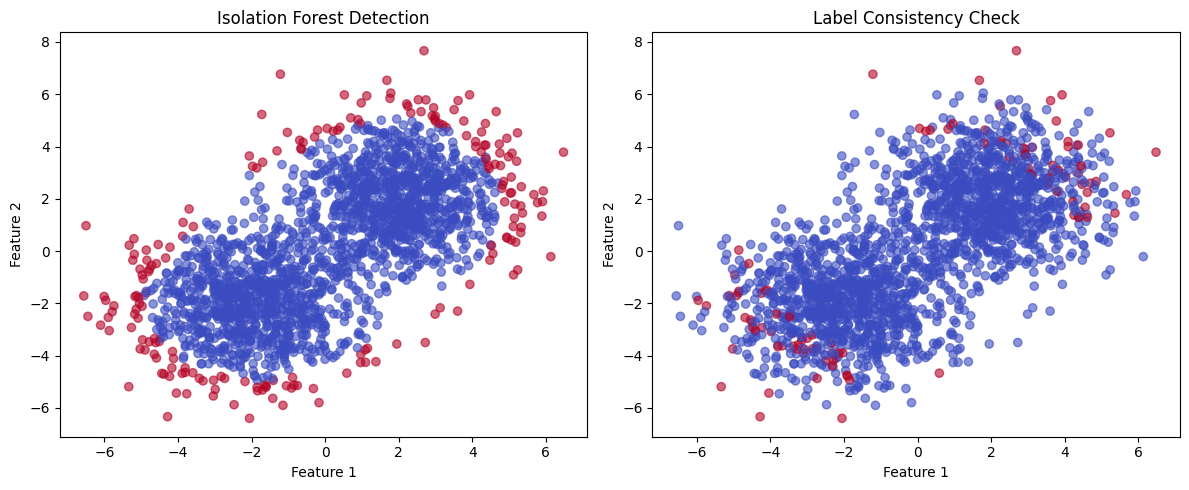

In [17]:
# Тест на отравленных данных
df = pd.read_csv("data/poisoned_flip_20.csv")
detector = PoisoningDetector()
df = detector.fit_detect(df)
df = detector.label_consistency_check(df)

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['feature_1'], df['feature_2'], c=df['is_anomaly'], cmap='coolwarm', alpha=0.6)
plt.title('Isolation Forest Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(df['feature_1'], df['feature_2'], c=df['suspicious'], cmap='coolwarm', alpha=0.6)
plt.title('Label Consistency Check')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.savefig("detection_results.png", dpi=300)
plt.show()